# Data

## Import libraries and Set Options

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, ParameterGrid, cross_val_score
from sklearn.preprocessing import (StandardScaler, OneHotEncoder,
                                   PolynomialFeatures)
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error

from daftpy.daftmodel import split_data, scores_statistics, metrics_regression, plot_learning_curves, compare_models

import joblib

In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

## Load Data

In [9]:
data = pd.read_csv('data_available/selected_data.csv', sep=',')
data.shape  #### cambiar esto

(7344, 9)

In [10]:
num_features = list(data.select_dtypes('number').columns) #X_train
num_features.remove('price')
cat_features =  list(data.select_dtypes('object').columns)

num_feat_df = pd.DataFrame({'numerical': num_features}) 
cat_feat_df = pd.DataFrame({'categorical': cat_features})

feat_df = num_feat_df.merge(cat_feat_df, how='left', left_index=True, right_index=True).fillna(' ')
feat_df

,numerical,categorical
0,floor_area,place
1,bedroom,type_house
2,bathroom,city_district
3,longitude,
4,latitude,


In [6]:
levels_type_house = data.type_house.unique()
levels_code = data.code.unique()

cat_feat_df['n_levels'] = [data.type_house.nunique(), data.code.nunique()]
cat_feat_df['sample'] = [levels_type_house, levels_code[:5]]
cat_feat_df # mejorar

,categorical,n_levels,sample
0,type_house,2,"[house, apartment]"
1,code,137,"[D09, T23, F91, V95, R32]"


## Split Data

In [7]:
X_train, X_test, y_train, y_test = split_data(data=data, 
                                              target='price', 
                                              test_size=.2, 
                                              output='X_y_train_test',
                                              random_state=42)

X_train: (5909, 7) 
X_test: (1478, 7) 
y_train: (5909,) 
y_test: (1478,) 



------------

# Metrics

In [8]:
scoring = {'r2': 'r2', 
           'MAE': 'neg_mean_absolute_error', 
           'MAPE': 'neg_mean_absolute_percentage_error', 
           'RMSE': 'neg_root_mean_squared_error'}

# Models

## Multiple Linear Regression

En estadística, el **coeficiente de determinación**, denominado R² y pronunciado R cuadrado, es un estadístico usado en el contexto de un modelo estadístico cuyo principal propósito es predecir futuros resultados o probar una hipótesis. El coeficiente determina la calidad del modelo para replicar los resultados, y la proporción de variación de los resultados que puede explicarse por el modelo.

Es el porcentaje de la variación en la variable de respuesta que es explicado por un modelo lineal. Es decir:

R-cuadrado = Variación explicada / variación total

El R-cuadrado siempre está entre 0 y 100%:

https://scikit-learn.org/stable/modules/cross_validation.html

In [9]:
num_pipe = Pipeline([
    ('std_scaler', StandardScaler()),
#    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ])

cat_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder(categories=[levels_type_house, levels_code]))  # No hace nada si ya transformadas
                                      #handle_unknown='ignore'
    ])
# Las transforme antes para evitar problemas no las variables a la hora de predecir e el test_set...

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features),
    ]) #, remainder='passthrough'


lr_pipe_estimator = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', # esto lo puedo agnadir en los otros pipes
                              fill_value=None)),
    ('regressor', LinearRegression())
    ])

In [10]:
scores_lr, scores_resume_lr = scores_statistics(estimator=lr_pipe_estimator, 
                                                scoring_dict=scoring, 
                                                X_train=X_train, 
                                                y_train=y_train, 
                                                cv=10, 
                                                return_train_score=False)

r2 mean: 0.6581505970522035
r2 std: 0.03247492814306588 

MAE mean: -108719.58221709491
MAE std: 5568.4947907050655 

MAPE mean: -0.32069981130761466
MAPE std: 0.015889144852600887 

RMSE mean: -176983.98634043717
RMSE std: 12945.409397794008 



### Overfitting Analysis

#### Evaluating on the Training and Test Sets

We can identify if a machine learning model has overfit by first evaluating the model on the training dataset and then evaluating the same model on a holdout test dataset.

If the performance of the model on the training dataset is significantly better than the performance on the test dataset, then the model may have overfit the training dataset.

In [11]:
lr = lr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = lr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = lr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.6739892726197527
MAE: 106081.66588347829
MAPE: 0.31183387356867376
RMSE: 173716.41014659725

Performance on the test set:
 ----------
R²: 0.6468123069342815
MAE: 111099.76275851484
MAPE: 0.321239513969634
RMSE: 183180.30027983472



#### Learning Curves

The model is underfitting the training data, so we need to use more complex models or come up with better features.

-------------

------------

--------------

In [12]:
#joblib.dump(lr, 'models/linear_regression_01-11-2021.plk')

-------------------

## Regularized Linear Models

In [13]:
data.shape

(7387, 8)

In [14]:
df_dum = pd.get_dummies(data.copy())
df_dum.shape

(7387, 145)

In [15]:
# Train test split

from sklearn.model_selection import train_test_split

y = df_dum.price.values
X = df_dum.drop('price', axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5909, 144), (1478, 144), (5909,), (1478,))

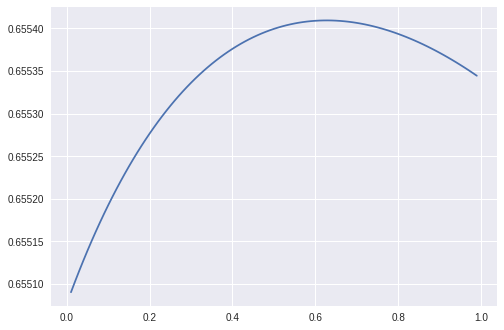

In [16]:
# Ridge Regression
from sklearn.linear_model import Ridge

alpha = []
error = []

for i in range(1,100):
    value = i/100
    alpha.append(value)
    ridge = Ridge(alpha=value, solver='cholesky')
    error.append(np.mean(cross_val_score(ridge, X_train, y_train, scoring='r2', cv=3)))
    
plt.plot(alpha, error);

In [17]:
err = tuple(zip(alpha, error))
df_err = pd.DataFrame(err, columns=['alpha', 'error'])
df_err[df_err.error == max(df_err.error)]

,alpha,error
62,0.63,0.655409


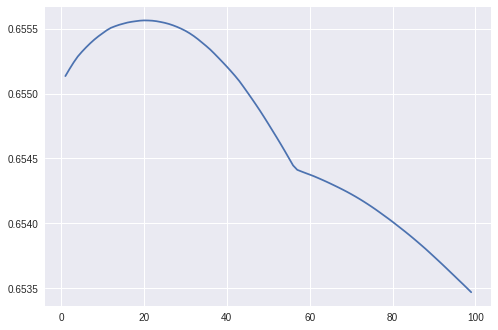

In [18]:
# Lasso Regression
from sklearn.linear_model import Lasso

alpha = []
error = []

for i in range(1,100):
    value = i
    alpha.append(value)
    lasso = Lasso(alpha=value)
    error.append(np.mean(cross_val_score(lasso, X_train, y_train, scoring='r2', cv=3)))
    
plt.plot(alpha, error);

In [19]:
err = tuple(zip(alpha, error))
df_err = pd.DataFrame(err, columns=['alpha', 'error'])
df_err[df_err.error == max(df_err.error)]

,alpha,error
19,20,0.655564


In [20]:
ridge = Ridge(alpha=.63, solver='cholesky').fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = ridge.predict(X_train)
metrics_regression(y_test=y_train, 
                    y_pred=y_pred_train, 
                    squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = ridge.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.6738303044717102
MAE: 105911.00915669053
MAPE: 0.311308569751956
RMSE: 173758.7584622816

Performance on the test set:
 ----------
R²: 0.6476035415776213
MAE: 110721.13344880374
MAPE: 0.32015762440309553
RMSE: 182974.99886540006



## Polynomial Regression

In [21]:
X_train, X_test, y_train, y_test = split_data(data=data, 
                                              target='price', 
                                              test_size=.2, 
                                              output='X_y_train_test',
                                              random_state=42)

X_train: (5909, 7) 
X_test: (1478, 7) 
y_train: (5909,) 
y_test: (1478,) 



In [22]:
num_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('std_scaler', StandardScaler()),
    ])

cat_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder(categories=[levels_type_house, levels_code])),  #code_levels
                                      #handle_unknown='ignore'
    ])


preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features),
    ]) #, remainder='passthrough'


poly_pipe_estimator = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', LinearRegression())
                           ])

In [23]:
grid_search = GridSearchCV(estimator=poly_pipe_estimator, 
                           param_grid={'preprocessor__num__poly__degree': range(1, 10)}, 
                           cv=5, 
                           n_jobs=-1,
                        #   scoring='neg_mean_squared_error',
                        #   return_train_score=True
                          )

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
#grid_search.best_estimator_

{'preprocessor__num__poly__degree': 3}
0.7479684669015497


In [24]:
#pd.DataFrame(grid_search.cv_results_) # plotearlo

In [25]:
scores = scores_statistics(estimator=poly_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=10, 
                           return_train_score=False)

r2 mean: 0.7509266721418995
r2 std: 0.029110140197970813 

MAE mean: -94476.7902938415
MAE std: 3679.6981417813968 

MAPE mean: -0.2738010265729388
MAPE std: 0.010822070061438843 

RMSE mean: -150821.55756749702
RMSE std: 10517.670372640698 



### Overfitting Analysis

In [26]:
poly = poly_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = poly.predict(X_train)
metrics_regression(y_test=y_train, 
                    y_pred=y_pred_train, 
                    squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = poly.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)


Performance on the training set:
 ----------
R²: 0.7737738943989698
MAE: 90784.73634486872
MAPE: 0.2629339442693284
RMSE: 144709.23924104206

Performance on the test set:
 ----------
R²: 0.7341027244460809
MAE: 97188.98815136666
MAPE: 0.271332077376683
RMSE: 158939.89776053437



## K Nearest Neighbors Regressor

In [27]:
from sklearn.neighbors import KNeighborsRegressor

In [28]:
num_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),
    ('std_scaler', StandardScaler()),
    ])

cat_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder(categories=[levels_type_house, levels_code]))  #code_levels
                                      #handle_unknown='ignore'
    ])


preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features),
    ]) #, remainder='passthrough'


knnr_pipe_est = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', KNeighborsRegressor())   #################
                           ])

```python
KNeighborsRegressor(n_neighbors=5, 
                    weights='uniform', 
                    algorithm='auto', 
                    leaf_size=30, 
                    p=2, 
                    metric='minkowski', 
                    metric_params=None, 
                    n_jobs=None)
```

In [29]:
param_grid = [
#    {
 #       'regressor__n_neighbors': [5,10,15,20,25,30,35,40,45,50], 
  #  },
    {
   #     'preprocessor__num__poly__degree': [1,2,3,4,5],
        'regressor__n_neighbors': [7],  ###########################
        'regressor__weights': ['uniform','distance'], #,'distance'
        'regressor__leaf_size': [30]
    }, 
]

grid_search = GridSearchCV(estimator=knnr_pipe_est, 
                           param_grid=param_grid,
                           cv=3, 
                           n_jobs=-1,
                        #   scoring='neg_mean_squared_error',
                        #   return_train_score=True
                          )

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'regressor__leaf_size': 30, 'regressor__n_neighbors': 7, 'regressor__weights': 'distance'}
0.7124120090874319


In [30]:
knnr_pipe_est = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', KNeighborsRegressor(n_neighbors=7,
                                      weights='uniform'
                                     ))
                           ])

scores = scores_statistics(estimator=knnr_pipe_est, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False)

r2 mean: 0.720356996746699
r2 std: 0.04726078613165459 

MAE mean: -94360.18126123537
MAE std: 3166.9588235767487 

MAPE mean: -0.2623233863553097
MAPE std: 0.007731494131750355 

RMSE mean: -160128.7532846894
RMSE std: 12202.415979408392 



### Overfitting Analysis

```python
KNeighborsRegressor(n_neighbors=5,  
                    weights='uniform', 
                    algorithm='auto', 
                    leaf_size=30, 
                    p=2, 
                    metric='minkowski', 
                    metric_params=None, 
                    n_jobs=None)
```

In [31]:
knnr = knnr_pipe_est.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = knnr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = knnr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.7986783708015246
MAE: 80209.40354906558
MAPE: 0.2213406428842462
RMSE: 136511.77663760813

Performance on the test set:
 ----------
R²: 0.7172472308799294
MAE: 94092.50898898125
MAPE: 0.2558942574938089
RMSE: 163900.17565319216



### Distribucion de los Errores

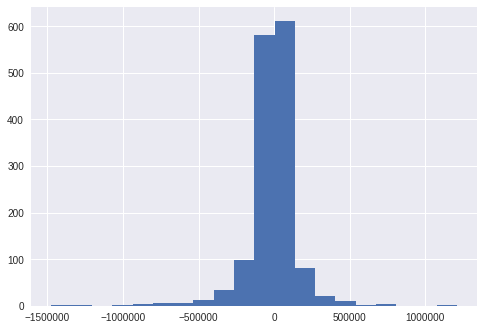

In [32]:
knnr = knnr_pipe_est.fit(X_train, y_train)
y_pred_test = knnr.predict(X_test)

fig, ax =plt.subplots(1, 1)
ax.hist(y_pred_test - y_test, bins=20); # estamos restando a la prediccion la verdad
# distribucion de los errores
ax.ticklabel_format(style='plain', axis='x')

In [33]:
np.std(y_pred_test - y_test)

163739.12985059066

## Decision Tree Regressor

In [34]:
num_pipe = Pipeline([
    ('std_scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),
    ])

cat_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder(categories=[levels_type_house, levels_code]))  #code_levels
                                      #handle_unknown='ignore'
    ])


preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features),
    ]) #, remainder='passthrough'


dtr_pipe_estimator = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', DecisionTreeRegressor()) # max_depth=9spoiler
                           ])

```python
DecisionTreeRegressor(*, criterion='squared_error', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0)
```

In [35]:
grid_search = GridSearchCV(estimator=dtr_pipe_estimator, 
                           param_grid={
                               'preprocessor__num__poly__degree': [1], #[1,2,3,4],
                               'regressor__max_depth': [6,7,8,9,10], #range(5, 15), #[2,3,4,5,6,7]
                               'regressor__min_samples_leaf': [12,13,14,15,16,17,18], #range(8, 20),
                               'regressor__min_samples_split': [43], #[2, 43],
                               'regressor__max_leaf_nodes': [68],
                         #      'regressor__max_features':,
                           }, 
                           cv=5, 
                           n_jobs=-1,
                        #   scoring='neg_mean_squared_error',
                        #   return_train_score=True
                          )

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)


{'preprocessor__num__poly__degree': 1, 'regressor__max_depth': 9, 'regressor__max_leaf_nodes': 68, 'regressor__min_samples_leaf': 16, 'regressor__min_samples_split': 43}
0.7350810549666685


In [36]:
#pd.DataFrame(grid_search.cv_results_)

In [37]:
dtr_pipe_estimator = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', DecisionTreeRegressor(max_depth=9,
                                        min_samples_leaf=16,  #16
                                        min_samples_split=43,
                                        max_leaf_nodes=68
                                       )) 
                           ])

scores = scores_statistics(estimator=dtr_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False)

r2 mean: 0.7350810549666685
r2 std: 0.024591821745795203 

MAE mean: -95188.05586328701
MAE std: 1588.1100149899914 

MAPE mean: -0.2762505668897066
MAPE std: 0.006086016411818382 

RMSE mean: -156416.72037856968
RMSE std: 7748.604233566981 



### Overfitting Analysis

In [38]:
dtr = dtr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = dtr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = dtr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.7927341211787164
MAE: 86542.06835968455
MAPE: 0.25752620175637614
RMSE: 138512.4486203107

Performance on the test set:
 ----------
R²: 0.7304601782182829
MAE: 96912.11046384604
MAPE: 0.27164761682651445
RMSE: 160024.8593006069



### Distribucion de los Errores

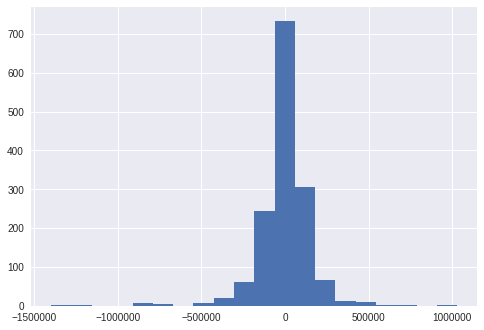

In [39]:
dtr = dtr_pipe_estimator.fit(X_train, y_train)
y_pred_test = dtr.predict(X_test)

fig, ax =plt.subplots(1, 1)
ax.hist(y_pred_test - y_test, bins=20); # estamos restando a la prediccion la verdad
# distribucion de los errores
ax.ticklabel_format(style='plain', axis='x')

In [40]:
np.std(y_pred_test - y_test)

159968.46938244888

## Voting Regressor with Basic Algorithms

In [41]:
from sklearn.ensemble import VotingRegressor

In [42]:
scoring_comp = {'r2': 'r2',
                'MAPE': 'neg_mean_absolute_percentage_error'}

Con el random forest mejora un poco pero el rfr sigue siendo mejor

In [43]:
models_r2 = {'poly': 73.41, 'knn': 71.49, 'dt': 73.04}

tot = 0
for key in models_r2:
    tot += models_r2[key]

models_weigth = {}
models_weigth_list = []
for key in models_r2:
    weight = models_r2[key] / tot
    models_weigth[key] = weight
    models_weigth_list.append(weight)
models_weigth
#models_weigth_list

{'poly': 0.33683582637423143,
 'knn': 0.3280260622189593,
 'dt': 0.33513811140680927}

In [44]:
polyr = poly_pipe_estimator
knnr = knnr_pipe_est
dtr = dtr_pipe_estimator
#rfr = rfr_pipe_est

voting_reg = VotingRegressor(
    estimators= [('poly', polyr),('knn', knnr),('dt', dtr)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {'Polynomial Regression': polyr, 
               'K Nearest Neighbors Regressor': knnr, 
               'Decission Tree Regressor': dtr, 
             #  'Random Forest Regressor': rfr,
               'Voting Regressor': voting_reg}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Polynomial Regression
r2 mean: 0.7509266721418995
MAPE mean: -0.2738010265729388
----------
K Nearest Neighbors Regressor
r2 mean: 0.7241851307348128
MAPE mean: -0.2593432160479623
----------
Decission Tree Regressor
r2 mean: 0.7191594146557667
MAPE mean: -0.2802377795333606
----------
Voting Regressor
r2 mean: 0.7853885812369799
MAPE mean: -0.23288328424995655
----------


In [45]:
voting_reg.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_reg.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_reg.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8312331389146667
MAE: 75131.68448705049
MAPE: 0.21298528909778375
RMSE: 124988.0484786615

Performance on the test set:
 ----------
R²: 0.782549175309982
MAE: 83409.16318385598
MAPE: 0.22466104239105456
RMSE: 143733.00822142744



## Bagging with Polynomial Regression

In [46]:
from sklearn.ensemble import BaggingRegressor

In [47]:
bag_regression = BaggingRegressor(
    
    base_estimator=LinearRegression(),
    n_estimators=500, 
    max_samples=3000, 
#    max_features=50, 
#    bootstrap=True, 
#    bootstrap_features=False, 
#    oob_score=True, 
#    warm_start=False, 
    n_jobs=-1, 
    random_state=42, 
#    verbose=0
)

'''
    base_estimator=LinearRegression(),
    n_estimators=500, 
    max_samples=2000, 
#    max_features=1.0, 
#    bootstrap=True, 
#    bootstrap_features=False, 
#    oob_score=True, 
#    warm_start=False, 
    n_jobs=-1, 
    random_state=42, 
#    verbose=0
----------------
R²: 0.7724293692138182
R²: 0.7353834187513661
'''

'\n    base_estimator=LinearRegression(),\n    n_estimators=500, \n    max_samples=2000, \n#    max_features=1.0, \n#    bootstrap=True, \n#    bootstrap_features=False, \n#    oob_score=True, \n#    warm_start=False, \n    n_jobs=-1, \n    random_state=42, \n#    verbose=0\n----------------\nR²: 0.7724293692138182\nR²: 0.7353834187513661\n'

In [48]:
num_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('std_scaler', StandardScaler()),
    ])

cat_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder(categories=[levels_type_house, levels_code]))  #code_levels
                                      #handle_unknown='ignore'
    ])


preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features),
    ]) #, remainder='passthrough'


br_pipe_estimator = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', bag_regression)
                           ])

In [49]:
scores = scores_statistics(estimator=br_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False)

r2 mean: 0.7484789696386661
r2 std: 0.017753527029554746 

MAE mean: -95150.15336594477
MAE std: 1727.5519094446418 

MAPE mean: -0.2763390928317644
MAPE std: 0.007261276392903534 

RMSE mean: -152427.59771405012
RMSE std: 4919.43221337097 



In [50]:
bag_reg = br_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = bag_reg.predict(X_train)
metrics_regression(y_test=y_train, 
                    y_pred=y_pred_train, 
                    squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = bag_reg.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.773131274043742
MAE: 90769.90056477503
MAPE: 0.2623421235946354
RMSE: 144914.62481491736

Performance on the test set:
 ----------
R²: 0.735524880514952
MAE: 96883.90805520506
MAPE: 0.26972445640914205
RMSE: 158514.28152992387



## Random Forest Regressor

In [51]:
num_pipe = Pipeline([
    ('std_scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),
    ])

cat_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder(categories=[levels_type_house, levels_code]))  #code_levels
                                      #handle_unknown='ignore'
    ])


preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features),
    ]) #, remainder='passthrough'


rfr_pipe_est = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', RandomForestRegressor(n_estimators=100, 
                               #         *, 
                                        criterion='squared_error',
                                        max_depth=None, 
                                        min_samples_split=2, 
                                        min_samples_leaf=1, 
                                        min_weight_fraction_leaf=0.0, 
                                        max_features='auto', 
                                        max_leaf_nodes=None, 
                                        min_impurity_decrease=0.0, 
                                        bootstrap=True, 
                                        oob_score=False, 
                                        n_jobs=None, 
                                        random_state=None, 
                                        verbose=0, 
                                        warm_start=False, 
                                        ccp_alpha=0.0, 
                                        max_samples=None)
    )
                           ])

In [ ]:
param_grid = [
    {
#        'preprocessor__num__poly__degree': [1, 3],
        'regressor__n_estimators': [320], 
        'regressor__max_depth': [9],#[10],
        'regressor__min_samples_split':range(30, 50), #[43],
        'regressor__min_samples_leaf': range(5, 20),#[16],
        'regressor__max_leaf_nodes': range(40, 80),#[68],
        'regressor__n_jobs': [-1],
    },
    #{'regressor__n_estimators': range(41,70)}, #[3,10,30,40,50,60]
]


grid_search = GridSearchCV(estimator=rfr_pipe_est, 
                           param_grid=param_grid,
                           cv=5, 
                           n_jobs=-1,
                        #   scoring='neg_mean_squared_error',
                        #   return_train_score=True
                          )

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

In [52]:
#pd.DataFrame(grid_search.cv_results_).tail()

In [ ]:
rfr_pipe_est = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', RandomForestRegressor(
        n_estimators=320, 
#        max_depth=9,  # 9
 #       min_samples_split=20,  # 43
  #      min_samples_leaf=16,   #16
   #     max_leaf_nodes=68,   #68
        n_jobs=-1,  
                                       )) 
                           ])
#estimator

scores = scores_statistics(estimator=rfr_pipe_est, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False)

In [53]:
rfr = rfr_pipe_est.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = rfr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = rfr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.9738369361580733
MAE: 28296.78447114571
MAPE: 0.07966000472137386
RMSE: 49211.79442940329

Performance on the test set:
 ----------
R²: 0.8062782030062432
MAE: 77586.20200947227
MAPE: 0.21047020328670138
RMSE: 135664.19122211242



The model is overfitting the training data. Necesitamos regularizar!!

## Extremely Randomized Trees

In [54]:
from sklearn.ensemble import ExtraTreesRegressor

In [55]:
num_pipe = Pipeline([
    ('std_scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),
    ])

cat_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder(categories=[levels_type_house, levels_code]))  #code_levels
                                      #handle_unknown='ignore'
    ])


preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features),
    ]) #, remainder='passthrough'


etr_pipe_est = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', ExtraTreesRegressor(n_estimators=100, 
                            #          *, 
                                      criterion='squared_error', 
                                      max_depth=None, 
                                      min_samples_split=2, 
                                      min_samples_leaf=1, 
                                      min_weight_fraction_leaf=0.0, 
                                      max_features='auto', 
                                      max_leaf_nodes=None, 
                                      min_impurity_decrease=0.0, 
                                      bootstrap=False, 
                                      oob_score=False, 
                                      n_jobs=-1, 
                                      random_state=None, 
                                      verbose=0, 
                                      warm_start=False, 
                                      ccp_alpha=0.0, 
                                      max_samples=None)
    )
                           ])

In [56]:
etr_pipe_est = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', ExtraTreesRegressor(n_estimators=100, 
                            #          *, 
                                      criterion='squared_error', 
                                      max_depth=None, 
                                      min_samples_split=2, 
                                      min_samples_leaf=1, 
                                      min_weight_fraction_leaf=0.0, 
                                      max_features='auto', 
                                      max_leaf_nodes=None, 
                                      min_impurity_decrease=0.0, 
                                      bootstrap=False, 
                                      oob_score=False, 
                                      n_jobs=-1, 
                                      random_state=None, 
                                      verbose=0, 
                                      warm_start=False, 
                                      ccp_alpha=0.0, 
                                      max_samples=None)
    )
                           ])

scores = scores_statistics(estimator=etr_pipe_est, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=10, 
                           return_train_score=False)

r2 mean: 0.8125724518820778
r2 std: 0.03529617685367397 

MAE mean: -76372.88593005536
MAE std: 4295.728433760647 

MAPE mean: -0.21567619976055546
MAPE std: 0.010093792800709276 

RMSE mean: -130171.34589868961
RMSE std: 11170.958998661185 



In [57]:
etr = etr_pipe_est.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = etr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = etr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.9999998702397691
MAE: 4.603147740734473
MAPE: 1.7799165941070736e-05
RMSE: 109.59625283730742

Performance on the test set:
 ----------
R²: 0.8189993507813427
MAE: 76957.70445872801
MAPE: 0.20479943262417294
RMSE: 131134.2243854076



## AdaBoost

In [58]:
from sklearn.ensemble import AdaBoostRegressor

In [59]:
num_pipe = Pipeline([
    ('std_scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),
    ])

cat_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder(categories=[levels_type_house, levels_code]))  #code_levels
                                      #handle_unknown='ignore'
    ])


preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features),
    ]) #, remainder='passthrough'


adaboost_pipe_est = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), 
                              #      *, 
                                    n_estimators=50, 
                                    learning_rate=1.0, 
                                    loss='linear', 
                                    random_state=42))
                           ])

In [60]:
adaboost_pipe_est = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', AdaBoostRegressor(base_estimator=None, 
                              #      *, 
                                    n_estimators=3, 
                                    learning_rate=1.0, 
                                    loss='linear', 
                                    random_state=42))
                           ])

scores = scores_statistics(estimator=adaboost_pipe_est, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=10, 
                           return_train_score=False)

r2 mean: 0.6422642094394672
r2 std: 0.045081241398125756 

MAE mean: -122834.34681543028
MAE std: 4608.233441167535 

MAPE mean: -0.4030357828910572
MAPE std: 0.022817423528780835 

RMSE mean: -180430.7810183822
RMSE std: 8430.422906990498 



In [61]:
adaboost = adaboost_pipe_est.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = adaboost.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = adaboost.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.6825632436915089
MAE: 116749.91257832848
MAPE: 0.38086430496936213
RMSE: 171416.84878404267

Performance on the test set:
 ----------
R²: 0.6400955083561792
MAE: 122317.9107731734
MAPE: 0.37215236374014693
RMSE: 184913.92579798016



## Gradient Boosting Regressor

In [62]:
from sklearn.ensemble import GradientBoostingRegressor

In [63]:
num_pipe = Pipeline([
    ('std_scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),
    ])

cat_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder(categories=[levels_type_house, levels_code]))  #code_levels
                                      #handle_unknown='ignore'
    ])


preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features),
    ]) #, remainder='passthrough'


gb_pipe_est = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', GradientBoostingRegressor())
                           ])

In [64]:
gb_pipe_est = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', AdaBoostRegressor(base_estimator=None, 
                              #      *, 
                                    n_estimators=3, 
                                    learning_rate=1.0, 
                                    loss='linear', 
                                    random_state=42))
                           ])

scores = scores_statistics(estimator=gb_pipe_est, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=10, 
                           return_train_score=False)

r2 mean: 0.6422642094394672
r2 std: 0.045081241398125756 

MAE mean: -122834.34681543028
MAE std: 4608.233441167535 

MAPE mean: -0.4030357828910572
MAPE std: 0.022817423528780835 

RMSE mean: -180430.7810183822
RMSE std: 8430.422906990498 



In [65]:
gboost = gb_pipe_est.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = gboost.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = gboost.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.6825632436915089
MAE: 116749.91257832848
MAPE: 0.38086430496936213
RMSE: 171416.84878404267

Performance on the test set:
 ----------
R²: 0.6400955083561792
MAE: 122317.9107731734
MAPE: 0.37215236374014693
RMSE: 184913.92579798016



## Extreme Gradient Boosting

In [66]:
from xgboost import XGBRegressor

In [67]:
num_pipe = Pipeline([
    ('std_scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),
    ])

cat_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder(categories=[levels_type_house, levels_code]))  #code_levels
                                      #handle_unknown='ignore'
    ])


preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features),
    ]) #, remainder='passthrough'




xgb_pipe_est = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', XGBRegressor())
                           ])

In [68]:
xgb_pipe_est = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', XGBRegressor(n_estimators= 105))
                           ])

scores = scores_statistics(estimator=xgb_pipe_est, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=10, 
                           return_train_score=False)

r2 mean: 0.8103256306854135
r2 std: 0.031107022249743918 

MAE mean: -76439.83677913898
MAE std: 3411.9054419745694 

MAPE mean: -0.21207778513758738
MAPE std: 0.007134753254566564 

RMSE mean: -131197.21047948365
RMSE std: 11002.37791559043 



In [69]:
xgb = xgb_pipe_est.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = xgb.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = xgb.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.9620408504154799
MAE: 40626.77943735192
MAPE: 0.13112311227814163
RMSE: 59276.57986186307

Performance on the test set:
 ----------
R²: 0.7992571055286443
MAE: 78311.53892506765
MAPE: 0.203086652634719
RMSE: 138100.76251426517



## Voting Regressor with Ensemble Methods

In [70]:
models_r2 = {'poly': 73.41, 'rfr': 80.92, 'etr': 81.75, 'xgb': 79.92} # estoy usando las del train set, no las del test set com antes 

tot = 0
for key in models_r2:
    tot += models_r2[key]

models_weigth = {}
models_weigth_list = []
for key in models_r2:
    weight = models_r2[key] / tot
    models_weigth[key] = weight
    models_weigth_list.append(weight)
models_weigth
#models_weigth_list

{'poly': 0.23231012658227848,
 'rfr': 0.2560759493670886,
 'etr': 0.2587025316455696,
 'xgb': 0.2529113924050633}

In [71]:
polyr = poly_pipe_estimator
rfr = rfr_pipe_est
etr = etr_pipe_est
egb = xgb_pipe_est

voting_regressor = VotingRegressor(
    estimators= [('poly', polyr),
                 ('rf', rfr),
                 ('et', etr),
                 ('egb', egb)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {'Polynomial Regression': polyr, 
               'Random Forest Regressor': rfr, 
               'Extra Trees Regressor': etr,
               'XGBoost': egb,
               'Voting Regressor': voting_regressor}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Polynomial Regression
r2 mean: 0.7509266721418995
MAPE mean: -0.2738010265729388
----------
Random Forest Regressor
r2 mean: 0.8057678847047166
MAPE mean: -0.2168220212876626
----------
Extra Trees Regressor
r2 mean: 0.8152070816017061
MAPE mean: -0.21537993289632434
----------
XGBoost
r2 mean: 0.8103256306854135
MAPE mean: -0.21207778513758738
----------
Voting Regressor
r2 mean: 0.8253792917607334
MAPE mean: -0.20892677208958554
----------


In [72]:
voting_regressor.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.9670166576049994
MAE: 35766.032370847584
MAPE: 0.10507454330199723
RMSE: 55255.082574533146

Performance on the test set:
 ----------
R²: 0.8191887389382323
MAE: 75443.88920169654
MAPE: 0.1991302827136437
RMSE: 131065.60096029431



Y si en lugar de usar el Polynomial Regression usamos el Voting Regressor with Basic Algorithms?

In [73]:
models_r2 = {'voting_reg': 77.81, 'rfr': 80.92, 'etr': 81.75, 'xgb': 79.92} # estoy usando las del train set, no las del test set com antes 

tot = 0
for key in models_r2:
    tot += models_r2[key]

models_weigth = {}
models_weigth_list = []
for key in models_r2:
    weight = models_r2[key] / tot
    models_weigth[key] = weight
    models_weigth_list.append(weight)
models_weigth
#models_weigth_list

{'voting_reg': 0.24285268414481895,
 'rfr': 0.2525593008739076,
 'etr': 0.2551498127340824,
 'xgb': 0.249438202247191}

In [74]:
voting_reg = voting_reg
rfr = rfr_pipe_est
etr = etr_pipe_est
egb = xgb_pipe_est

voting_regressor = VotingRegressor(
    estimators= [('voting_reg', voting_reg),
                 ('rf', rfr),
                 ('et', etr),
                 ('egb', egb)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {'Voting Regressor BA': voting_reg, 
               'Random Forest Regressor': rfr, 
               'Extra Trees Regressor': etr,
               'XGBoost': egb,
               'Voting Regressor': voting_reg}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Voting Regressor BA
r2 mean: 0.7853885812369799
MAPE mean: -0.23288328424995655
----------
Random Forest Regressor
r2 mean: 0.8105781814723242
MAPE mean: -0.21575597763850288
----------
Extra Trees Regressor
r2 mean: 0.8141423246813249
MAPE mean: -0.21607767033481817
----------
XGBoost
r2 mean: 0.8103256306854135
MAPE mean: -0.21207778513758738
----------
Voting Regressor
r2 mean: 0.7853885812369799
MAPE mean: -0.23288328424995655
----------


In [75]:
voting_regressor.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.9695346776289329
MAE: 33828.25543648191
MAPE: 0.09983053251051754
RMSE: 53104.06781895789

Performance on the test set:
 ----------
R²: 0.8198348303733034
MAE: 74774.70473706788
MAPE: 0.20006509506465592
RMSE: 130831.22356563552



y sin ninguno?

In [80]:
models_r2 = {'rfr': 80.92, 'etr': 81.75, 'xgb': 79.92} # estoy usando las del train set, no las del test set com antes 

tot = 0
for key in models_r2:
    tot += models_r2[key]

models_weigth = {}
models_weigth_list = []
for key in models_r2:
    weight = models_r2[key] / tot
    models_weigth[key] = weight
    models_weigth_list.append(weight)
models_weigth
#models_weigth_list

{'rfr': 0.33356692361597756,
 'etr': 0.3369883342264726,
 'xgb': 0.32944474215754976}

In [81]:
#polyr = poly_pipe_estimator
rfr = rfr_pipe_est
etr = etr_pipe_est
egb = xgb_pipe_est

voting_regressor = VotingRegressor(
    estimators= [#('poly', polyr),
                 ('rf', rfr),
                 ('et', etr),
                 ('egb', egb)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {#'Polynomial Regression': polyr, 
               'Random Forest Regressor': rfr, 
               'Extra Trees Regressor': etr,
               'XGBoost': egb,
               'Voting Regressor': voting_regressor}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Random Forest Regressor
r2 mean: 0.8085763309186712
MAPE mean: -0.21639455320624873
----------
Extra Trees Regressor
r2 mean: 0.8136102822216513
MAPE mean: -0.2158918201107562
----------
XGBoost
r2 mean: 0.8103256306854135
MAPE mean: -0.21207778513758738
----------
Voting Regressor
r2 mean: 0.8239653490464885
MAPE mean: -0.2070768729790556
----------


In [82]:
voting_regressor.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.9879209881403586
MAE: 22120.814754155115
MAPE: 0.06772981017332462
RMSE: 33438.02395245741

Performance on the test set:
 ----------
R²: 0.8194482722811417
MAE: 74812.67756416505
MAPE: 0.1986440993841695
RMSE: 130971.50253804495



## Stacking

Regression Meta-Model: Linear Reagression

In [76]:
from sklearn.ensemble import StackingRegressor

In [77]:
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('polyr', poly_pipe_estimator))
    level0.append(('rfr', rfr_pipe_est))
    level0.append(('etr', etr_pipe_est))
    level0.append(('egb', xgb_pipe_est))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

In [78]:
models_dict = {'Polynomial Regression': poly_pipe_estimator, 
               'Random Forest Regressor': rfr_pipe_est, 
               'Extra Trees Regressor': etr_pipe_est,
               'XGBoost': xgb_pipe_est,
               'Stacking': get_stacking()}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Polynomial Regression
r2 mean: 0.7509266721418995
MAPE mean: -0.2738010265729388
----------
Random Forest Regressor
r2 mean: 0.8076729746434484
MAPE mean: -0.21606183775052648
----------
Extra Trees Regressor
r2 mean: 0.8155278256884833
MAPE mean: -0.21460297219466806
----------
XGBoost
r2 mean: 0.8103256306854135
MAPE mean: -0.21207778513758738
----------
Stacking
r2 mean: 0.8250694997363477
MAPE mean: -0.20516023208565753
----------


In [79]:
stacking = get_stacking()
stacking.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = stacking.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = stacking.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.9812665771174053
MAE: 28022.1344715855
MAPE: 0.08387216590746134
RMSE: 41642.181155186336

Performance on the test set:
 ----------
R²: 0.8210302467290974
MAE: 74723.81927116285
MAPE: 0.19503535367925787
RMSE: 130396.46117969579



# Dataset to try the frontend: